# Intro.
### M_05 & M_06에 대한 멘토님 피드백 반영하기
- 변수명을 좀 더 ```직관적```으로 선언하기
- 학습시 ```충분한 epoch 설정```하기
- 미션을 좀 더 ```연구적인 태도```로 임하기
    - 머신러닝 파이프라인을 진행하면서 과정이 끝날때 마다 ```추후에 오게 될 방향성```에 대한 글을 작성해보기
    - 코드를 실행하면 ```어떤 결과가 예상```되는지
    - 예측한 결과와 실제가 어떤 차이가 있는지, ```"왜"```라는 태도로 임하기
- 데이터 분석 및 시각화를 했으면 해당 ```결과에 대한 인사이트를 함께``` 적어서 코드를 읽는 ```다른 사람들이 읽기 쉽게 작성```해보기.

### Challenge
1. Data Augmentation
- 이미지 회전, 이동, 밝기 적용해보기

# Lib Import

In [73]:
import os
import cv2

import kagglehub

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


from pathlib import Path
from enum import Enum, auto

# Set GPU

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Load Dataset

In [43]:
# path = kagglehub.dataset_download("sadhliroomyprime/football-semantic-segmentation")

# print("Path to dataset files:", path)
BASE_DIR = Path().resolve().parent.parent
DATA_DIR = BASE_DIR / 'common' / 'data' / 'Football'
IMAGE_DIR = os.path.join(DATA_DIR, "images")

## [func] Set Image Pair

In [81]:
class ImageType(Enum):
    """
    이미지 타입을 나타내는 Enum 클래스

    STR: 이미지 파일 경로로 처리 (e.g., .jpg path)
    
    ND_ARRAY: Numpy array 형식으로 처리 (e.g., numpy.ndArray)
    """
    STR = auto()
    ND_ARRAY = auto()

In [101]:
class DetailedError(Exception):
    @staticmethod
    def unknown_image_type_error(image_type: ImageType):
        message = f"알 수 없는 이미지 타입입니다. (입력된 타입: {image_type} / 입력 가능한 타입: STR, ND_ARRAY)"
        return DetailedError(message)

    @staticmethod
    def match_failure_error():
        message = "fuse_files 리스트에서 base_name이 포함된 파일을 찾지 못했습니다."
        return DetailedError(message)
        

In [106]:
def set_image_pair(file_list, image_type: ImageType):
    ''' 
    원본 이미지(.jpg)와 fuse 이미지 매칭 
    Args:
        file_list (list): 매칭할 전체 file list
        image_type (Enum): pair로 저장할 이미지 데이터 타입
    Returns:
        image_pairs (list): 원본, fuse (tuple)
    '''
    image_pairs = []
    
    # 전체 파일 리스트(file_list)에서 .jpg 확장자
    original_files = sorted([f for f in file_list if f.endswith(".jpg")])

    # 전체 파일 리스트(file_list)의 파일 이름에서 'fuse'가 포함된 파일
    fuse_files = sorted([f for f in file_list if "fuse" in f])
    
    for orig_file in original_files:
        # 동일한 프레임의 fuse 파일 찾기
        base_name = orig_file.replace(".jpg", "")
        
        # fuse_files 리스트에서 base_name이 포함된 첫 번째 파일을 찾아서 fuse_file에 저장
        fuse_file = next((f for f in fuse_files if base_name in f), None)
        
        if fuse_file:
            if image_type == ImageType.ND_ARRAY:
                # 원본과 마스크 로드
                img_path = os.path.join(IMAGE_DIR, orig_file)
                # print(img_path)
                mask_path = os.path.join(IMAGE_DIR, fuse_file)

                img = cv2.imread(img_path)
                # print(f'img: {img.shape}')
                mask = cv2.imread(mask_path)
                # print(f'mask: {mask.shape}')

                if img is not None and mask is not None:
                    image_pairs.append((img, mask))
                    print(f'image: {img}')
                    print(f'mask: {mask}')
            elif image_type == ImageType.STR:
                image_pairs.append((orig_file, fuse_file))
            else:
                raise DetailedError.unknown_image_type_error(image_type)
        else:
            raise DetailedError.match_failure_error()
    
    return image_pairs

In [108]:
# 폴더 내 모든 파일 목록 가져오기
file_list = os.listdir(IMAGE_DIR)

image_pairs = set_image_pair(file_list, ImageType.STR)

print(image_pairs[0])

('Frame 1  (1).jpg', 'Frame 1  (1).jpg___fuse.png')


## Show Dataset Samples

In [109]:
def show_image_pair_subplot(image_pair_list, image_count=5):
    ''' 
    원본/fuse 이미지 쌍 subplot으로 보여주기
    Args:
        image_pair_list (list): 원본/fuse 이미지 쌍 리스트
        image_count (int, optional): 보여줄 원본/fuse 이미지 쌍 개수
    '''
    fig, axes = plt.subplots(image_count, 2, figsize=(10, 5 * image_count))
    
    for i, (orig_file, fuse_file) in enumerate(image_pair_list):
        # 이미지 로드
        orig_img = cv2.imread(os.path.join(IMAGE_DIR, orig_file))
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)  # OpenCV BGR → RGB 변환

        fuse_img = cv2.imread(os.path.join(IMAGE_DIR, fuse_file))
        fuse_img = cv2.cvtColor(fuse_img, cv2.COLOR_BGR2RGB)  # 마스크도 RGB 변환

        # 시각화
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f"Original: {orig_file}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(fuse_img)
        axes[i, 1].set_title(f"Fuse Mask: {fuse_file}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()
    

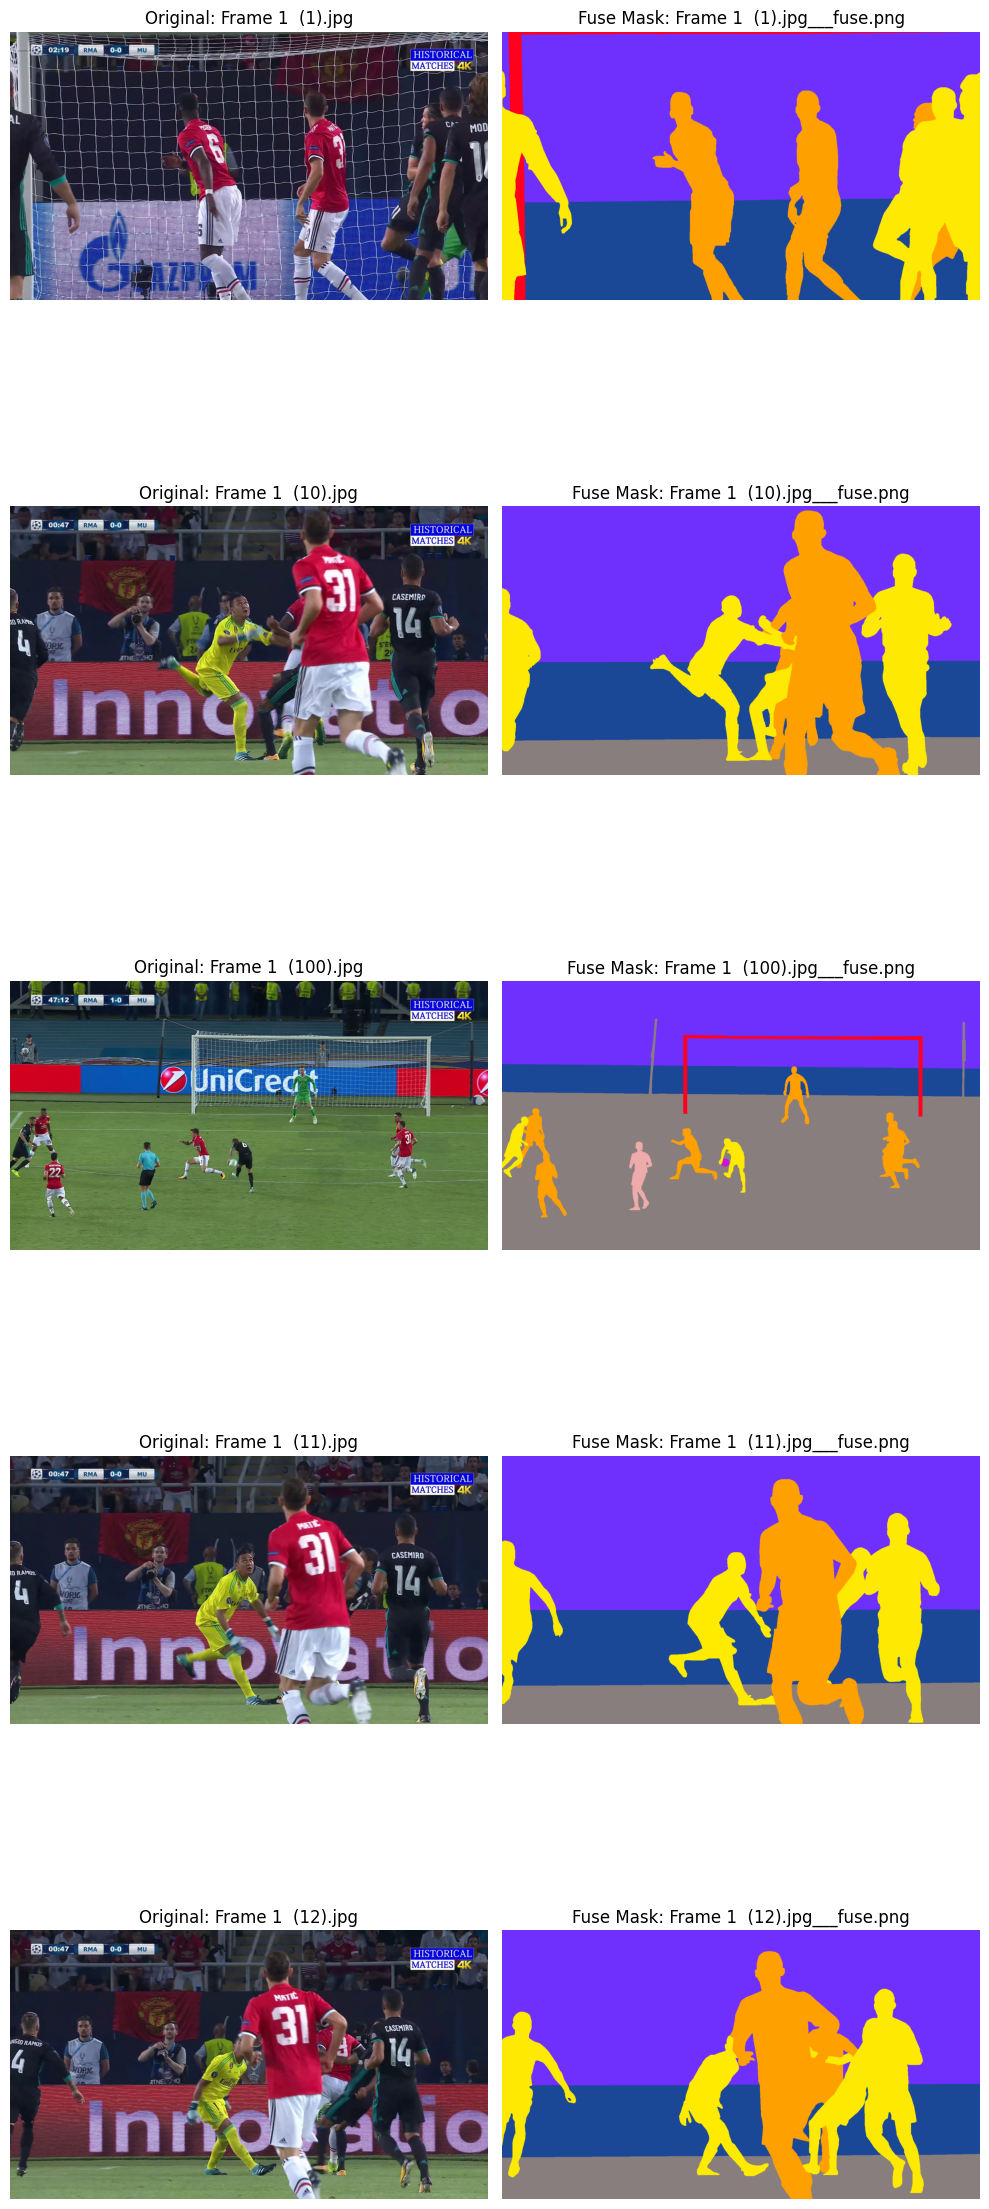

In [110]:
NUM_SAMPLE = 5

sample_pair_images = image_pairs[:NUM_SAMPLE]

show_image_pair_subplot(sample_pair_images)